<a href="https://colab.research.google.com/github/krucx/ML_from_scratch/blob/main/CGANs_Fashion_MNIST_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
(X_train,classes),(_,_) = tf.keras.datasets.fashion_mnist.load_data()
X_train.astype('float')
X_train = (X_train-127.5)/127.5
dataset = np.expand_dims(X_train,-1)
dataset.shape

4423680/4422102 [==============================] - 0s 0us/step


(60000, 28, 28, 1)

In [26]:
def display_from_dataset(dataset,n=6):
  data = np.squeeze(dataset, axis=-1)
  plt.figure(figsize=(10,10))
  for i in range(n*n):
    plt.subplot(n,n,1+i)
    plt.imshow(data[i],cmap='gray')
  plt.show()

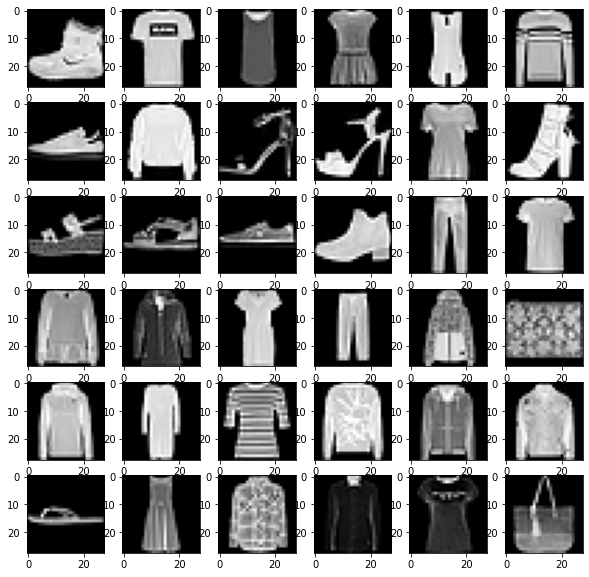

In [27]:
display_from_dataset(dataset)

In [6]:
def sample_real(dataset,classes,batch_size):
  idx = random.sample(range(0, dataset.shape[0]), batch_size)
  X = np.take(dataset, idx,axis=0)
  label = np.take(classes, idx,axis=0)
  Y = np.ones((batch_size,1))
  return [X,label],Y

In [7]:
def sample_fake(g_model,batch_size,latent_dims,n_classes):
  latent,labels = generate_latent(batch_size,latent_dims,n_classes)
  X = g_model.predict([latent,labels])
  Y = np.zeros((batch_size,1))
  return [X,labels],Y

In [8]:
def generate_latent(batch_size,latent_dims,n_classes):
  latent = np.random.randn(batch_size*latent_dims)
  latent = np.reshape(latent,(batch_size,latent_dims))
  labels = np.asarray([random.randint(0,n_classes-1) for i in range(batch_size)])
  return latent,labels

In [9]:
def define_discriminator(n_classes,input_dims = (28,28,1)):
  
  in_label = tf.keras.layers.Input(shape=(1,))
  l1 = tf.keras.layers.Embedding(n_classes,50)(in_label)
  l1 = tf.keras.layers.Dense(input_dims[0]*input_dims[1])(l1)
  l1 = tf.keras.layers.Reshape((input_dims[0],input_dims[1],1))(l1)

  in_image = tf.keras.layers.Input(shape=input_dims)
  fm = tf.keras.layers.Concatenate()([in_image,l1])
  fm = tf.keras.layers.Conv2D(128,(3,3),strides=(2,2),padding='same')(fm)
  fm =tf.keras.layers.LeakyReLU(alpha = 0.2)(fm)
  fm = tf.keras.layers.Conv2D(128,(3,3),strides=(2,2),padding='same')(fm)
  fm = tf.keras.layers.LeakyReLU(alpha = 0.2)(fm)
  fm = tf.keras.layers.Flatten()(fm)
  fm = tf.keras.layers.Dropout(0.4)(fm)
  out = tf.keras.layers.Dense(1,activation='sigmoid')(fm)

  model = tf.keras.Model(inputs=[in_image,in_label],outputs=out)

  opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(optimizer=opt, loss="binary_crossentropy",metrics=['accuracy'])
  return model

In [10]:
def define_generator(latent_dims,n_classes):

  in_label = tf.keras.layers.Input(shape=(1,))
  l1 = tf.keras.layers.Embedding(n_classes,50)(in_label)
  l1 = tf.keras.layers.Dense(7*7)(l1)
  l1 = tf.keras.layers.Reshape((7,7,1))(l1)

  in_latent = tf.keras.layers.Input(shape=(latent_dims,))
  lat =  tf.keras.layers.Dense(7*7*128)(in_latent)
  lat = tf.keras.layers.LeakyReLU(alpha=0.2)(lat)
  lat = tf.keras.layers.Reshape((7,7,128))(lat)
  
  fm = tf.keras.layers.Concatenate()([lat,l1])
  fm = tf.keras.layers.Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(fm)
  fm = tf.keras.layers.LeakyReLU(alpha = 0.2)(fm)
  fm = tf.keras.layers.Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(fm)
  fm = tf.keras.layers.LeakyReLU(alpha = 0.2)(fm)
  out = tf.keras.layers.Conv2D(1,(7,7),padding='same',activation='tanh')(fm)

  model = tf.keras.Model(inputs=[in_latent,in_label],outputs=out)
  return model

In [11]:
def define_gan(d_model,g_model):
  d_model.trainable = False

  g_latent, g_label = g_model.input
  g_out = g_model.output
  gan_out = d_model([g_out,g_label])
  model = tf.keras.Model(inputs=[g_latent,g_label],outputs=gan_out)

  opt = tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(optimizer=opt, loss="binary_crossentropy")
  return model

In [12]:
def train_gan(dataset,classes,gan_model,d_model,g_model,n_classes=10,latent_dims=100,epochs=20,batch_size=128):
  per_epoch = dataset.shape[0]//batch_size
  for i in range(epochs):
    for j in range(per_epoch):
      X_real,Y_real = sample_real(dataset,classes,batch_size//2)
      d_loss1,_ = d_model.train_on_batch(X_real,Y_real)
      X_fake,Y_fake = sample_fake(g_model,batch_size//2,latent_dims,n_classes)
      d_loss2,_ = d_model.train_on_batch(X_fake,Y_fake)

      latent,labels = generate_latent(batch_size,latent_dims,n_classes)
      y = np.ones((batch_size,1))
      gan_loss1 = gan_model.train_on_batch([latent,labels],y)
      print(f"Epoch {i} : {j}/{per_epoch} ===> D_real : {d_loss1} D_fake : {d_loss2} Gan_loss : {gan_loss1}")

In [13]:
latent_dims = 100
n_classes=10
d_model = define_discriminator(n_classes)
g_model = define_generator(latent_dims,n_classes)
gan_model = define_gan(d_model,g_model)
train_gan(dataset,classes,gan_model,d_model,g_model,n_classes,latent_dims)

Streaming output truncated to the last 5000 lines.
Epoch 9 : 148/468 ===> D_real : 0.6774661540985107 D_fake : 0.6710236668586731 Gan_loss : 0.7249577641487122
Epoch 9 : 149/468 ===> D_real : 0.6823204755783081 D_fake : 0.7068824768066406 Gan_loss : 0.7821279168128967
Epoch 9 : 150/468 ===> D_real : 0.7325992584228516 D_fake : 0.6445674896240234 Gan_loss : 0.8347558975219727
Epoch 9 : 151/468 ===> D_real : 0.6820956468582153 D_fake : 0.6051898002624512 Gan_loss : 0.8674525618553162
Epoch 9 : 152/468 ===> D_real : 0.6943461894989014 D_fake : 0.6797543168067932 Gan_loss : 0.7948154211044312
Epoch 9 : 153/468 ===> D_real : 0.7119531631469727 D_fake : 0.6878857612609863 Gan_loss : 0.7654419541358948
Epoch 9 : 154/468 ===> D_real : 0.680476188659668 D_fake : 0.673031210899353 Gan_loss : 0.7891730070114136
Epoch 9 : 155/468 ===> D_real : 0.6347833871841431 D_fake : 0.6684898138046265 Gan_loss : 0.8414008617401123
Epoch 9 : 156/468 ===> D_real : 0.6805026531219482 D_fake : 0.6682911515235901 

In [28]:
def show_samples(g_model,n_classes=10):
  latent,labels = generate_latent(n**2,latent_dims,n_classes)
  labels = np.asarray([i for _ in range(n) for i in range(n)])
  X = g_model.predict([latent,labels])
  display_from_dataset(X,n)

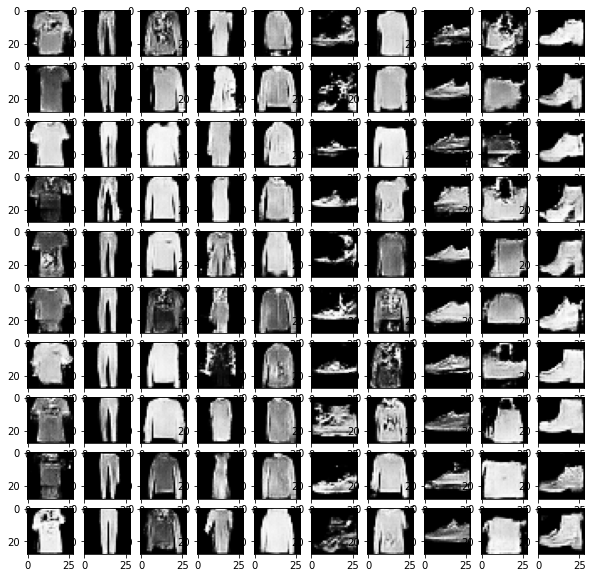

In [29]:
show_samples(g_model,10)